In [22]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from dotenv import load_dotenv
import os

In [23]:
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [24]:
from langchain_groq import ChatGroq

generator_llm = ChatGroq(model="qwen/qwen3-32b")
evaluator_llm = ChatGroq(model="qwen/qwen3-32b")
optimizer_llm = ChatGroq(model="qwen/qwen3-32b")

In [25]:
class TweetState(TypedDict):

  topic: str
  tweet: str
  evaluation: Literal["approved","needs_improvement"]
  feedback: str
  iteration: int
  max_iteration: int

  tweet_history: Annotated[list[str],operator.add]
  feedback_history: Annotated[list[str],operator.add]

In [26]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage
def generate_tweet(state: TweetState):

  messages = [
    SystemMessage(content="You are a funny and clever Twitter/X influencer."),
    HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
  ]

  response = generator_llm.invoke(messages).content

  return {'tweet': response,'tweet_history':[response]}

In [27]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):

  evaluation: Literal["approved","needs_improvement"] = Field(description="Final evaluation result.")
  feedback: str = Field(description="feedback for the tweet.")

In [28]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [29]:
def evaluate_tweet(state: TweetState):

  messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
  ]

  response = structured_evaluator_llm.invoke(messages)

  return {'evaluation': response.evaluation, 'feedback': [response.feedback], 'feedback_history': [response.feedback]}

  

In [30]:
def optimize_tweet(state: TweetState):

  messages =[
    SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
    HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
  ]

  response = optimizer_llm.invoke(messages).content
  iteration = state['iteration'] + 1

  return {'tweet': response,'iteration':iteration,'tweet_history': [response]}

In [31]:
def check_conditon(state: TweetState):

  if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
    return 'approved'
  else:
    return 'needs_improvement'


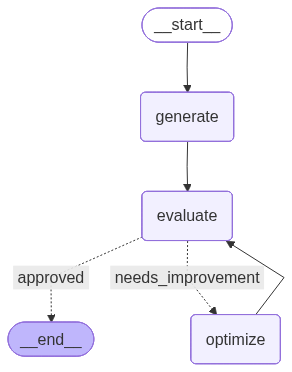

In [32]:
graph = StateGraph(TweetState)

graph.add_node("generate",generate_tweet)
graph.add_node("evaluate",evaluate_tweet)
graph.add_node("optimize",optimize_tweet)

graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')

graph.add_conditional_edges('evaluate',check_conditon, {'approved': END,'needs_improvement': 'optimize'})

graph.add_edge('optimize','evaluate')

workflow = graph.compile()

workflow


In [33]:
initial_state = {
  "topic": "About the growth of Agentic AI",
  "iteration": 1,
  "max_iteration": 5
  }

In [36]:
workflow.invoke(initial_state)

{'topic': 'About the growth of Agentic AI',
 'tweet': '<think>\nOkay, let\'s tackle this. The user wants a tweet about Agentic AI growth that\'s more viral and humorous based on the given feedback. The original tweet used a friend analogy but had a forced coffee line and a weak punchline.\n\nFirst, I need to maintain the relatable structure but make the analogy sharper. The feedback mentioned the coffee part felt forced, so maybe replace that with something more unexpected. The example uses a friend who oversteps, so perhaps use a different analogy. Maybe something like a "roommate" who takes over more than expected. \n\nThe original example uses "TED Talk" and "resignation letter" as ironic escalations. I should keep that kind of escalation but make it more specific. Maybe instead of coffee, use something like "ghostwriting your LinkedIn post" or "booking your next job interview." \n\nThe structure should be lean and punchy. Let\'s brainstorm a scenario where asking for a simple task 